# Solution for Labs: Visualize Correlation

In this notebook, you will visualize the correlation between two factors in Quantopian. Specifically, we want to see how today's news sentiment (from the [SentDex](https://www.quantopian.com/docs/data-reference/sentdex) dataset) affects tomorrow's asset returns.

When performing this kind of analysis, this is the train of thought that leads to a solution:

1. The goal is to align a particular factor's results to future returns. 
2. Window length gets a range of dates starting from the current date in the pipeline minus `window_length` days. Therefore, for a `window length` of 2, for instance, the inputs in the `compute()` function in a Factor should start from the `today` argument minus 2 days.

In that case, when we want to compare today's sentiment and tomorrow's asset returns, we want to get news sentiment from `today - 2` and `today`'s asset returns.

In [1]:
# Do not change anything in this code cell

from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.filters import StaticAssets
from quantopian.pipeline.factors import Returns, Latest

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

assets = StaticAssets(symbols(['FB', 'TSLA', 'NFLX', 'AMZN', 'GOOG']))


start_date = datetime.strptime('01/01/2018', '%m/%d/%Y') + pd.tseries.offsets.BDay(2)
end_date = datetime.strptime('01/01/2019', '%m/%d/%Y')


First of all, get an overview of the available BoundColumns of the `sentiment` dataset.

In [2]:
sentiment.columns

frozenset({sentiment<US>.asof_date::datetime64[ns],
           sentiment<US>.sentiment_signal::float64,
           sentiment<US>.symbol::object})

Build a custom factor to get sentiment signals with 2 days delay. 

In [3]:
# Todo: Create a Sentiment factor.
class Sentiment(CustomFactor):
    inputs=[sentiment.sentiment_signal]
    window_length=2
    def compute(self, today, assets, out, s):
        # The shape of `s` is (window_length, num of equities)
        # Therefore, to get the first date of `s`, for all equities,
        # we use s[0]
        out[:] = s[0]

Build a pipeline

In [4]:
# Todo: Build a pipeline with three columns.
return_d2 = Returns(window_length=2, mask=assets)
sentiment_d2 = Sentiment(window_length=2, mask=assets)

pipe = Pipeline(
    columns={
        'sentiment_today': sentiment.sentiment_signal.latest,
        'sentiment_d2': sentiment_d2,
        'return_d2': return_d2
    },
    screen=assets
)

mdf = run_pipeline(pipe, start_date, end_date)

## 1. Confirm that the Pipeline is correct

To confirm that our pipeline is correct, compare `sentiment_d2` with `sentiment_today`. The former should be delayed by 1 day, which means if 2018-01-03's NFLX's `sentiment_today` is 2.0, then 2018-01-04's NFLX's `sentiment_d2` should also be 2.0.

In [5]:
mdf.head(15)

return_d2  sentiment_d2  \
2018-01-03 00:00:00+00:00 Equity(16841 [AMZN])   0.016639          -1.0   
                          Equity(23709 [NFLX])   0.047235           6.0   
                          Equity(39840 [TSLA])   0.028548           2.0   
                          Equity(42950 [FB])     0.027816          -1.0   
                          Equity(46631 [GOOG])   0.017707           1.0   
2018-01-04 00:00:00+00:00 Equity(16841 [AMZN])   0.011808          -1.0   
                          Equity(23709 [NFLX])   0.019693           2.0   
                          Equity(39840 [TSLA])  -0.010241           3.0   
                          Equity(42950 [FB])     0.016811          -1.0   
                          Equity(46631 [GOOG])   0.015962           1.0   
2018-01-05 00:00:00+00:00 Equity(16841 [AMZN])   0.005486          -1.0   
                          Equity(23709 [NFLX])   0.002829           1.0   
                          Equity(39840 [TSLA])  -0.007539           3.0   
                          Equity(42950 [FB])    -0.000867           1.0   
                          Equity(46631 [GOOG])   0.004067          -3.0   

                                                sentiment_today  
2018-01-03 00:00:00+00:00 Equity(16841 [AMZN])             -1.0  
                          Equity(23709 [NFLX])              2.0  
                          Equity(39840 [TSLA])              3.0  
                          Equity(42950 [FB])               -1.0  
                          Equity(46631 [GOOG])              1.0  
2018-01-04 00:00:00+00:00 Equity(16841 [AMZN])             -1.0  
                          Equity(23709 [NFLX])              1.0  
                          Equity(39840 [TSLA])              3.0  
                          Equity(42950 [FB])                1.0  
                          Equity(46631 [GOOG])             -3.0  
2018-01-05 00:00:00+00:00 Equity(16841 [AMZN])             -1.0  
                          Equity(23709 [NFLX])             -1.0  
                          Equity(39840 [TSLA])              3.0  
                          Equity(42950 [FB])                6.0  
                          Equity(46631 [GOOG])             -3.0

Since we have confirmed the values, delete `sentiment_today` column, we do not need this in our visualization.

In [6]:
# Todo: Drop the `sentiment_today` column.
final_mdf = mdf.drop('sentiment_today', axis=1)
final_mdf.head(5)

return_d2  sentiment_d2
2018-01-03 00:00:00+00:00 Equity(16841 [AMZN])   0.016639          -1.0
                          Equity(23709 [NFLX])   0.047235           6.0
                          Equity(39840 [TSLA])   0.028548           2.0
                          Equity(42950 [FB])     0.027816          -1.0
                          Equity(46631 [GOOG])   0.017707           1.0

## 2. Plotting a Simple Correlation

[regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html) can be used to quickly visualize correlation by using a regression plot.

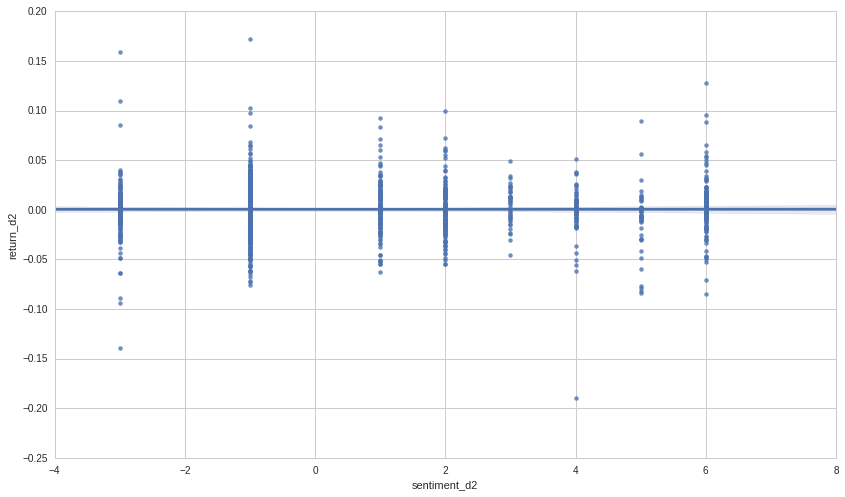

In [7]:
# Todo: Create a regplot.
sns.regplot(x='sentiment_d2', y='return_d2', data=final_mdf)

There are 3 problems in that plot:

1. It is hard to see the density of the areas of data points. This is because we have a discrete data for `sentiment_d2`. One solution is to jitter the data points horizontally. Find out how to do this from the [regplot's documentation](https://seaborn.pydata.org/generated/seaborn.regplot.html).
2. The ticker spacing is not ideal for discrete `sentiment_d2` values. We will adjust the spacing using `xaxis.set_ticks()` function, passing in an array of numbers between -4 and 8 using [`np.arange`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html) function.

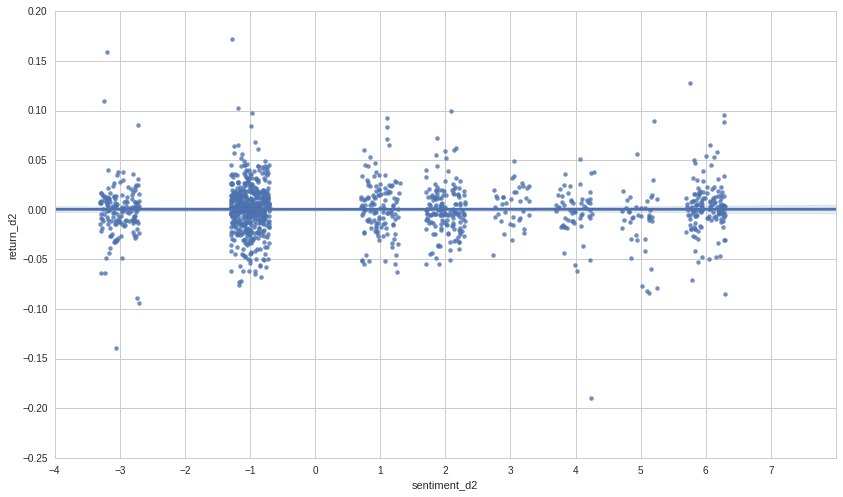

In [8]:
# Todo: Add horizontal jittering and set the ticks on xaxis
#       so it shows all the sentiment scores.
import numpy as np

ax = sns.regplot(x='sentiment_d2', y='return_d2', data=final_mdf, x_jitter=0.3)
ax.xaxis.set_ticks(np.arange(-4, 8, 1));

Zooming-in can be done with [`matplotlib.axes.Axes.set_ylim()`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_ylim.html) function

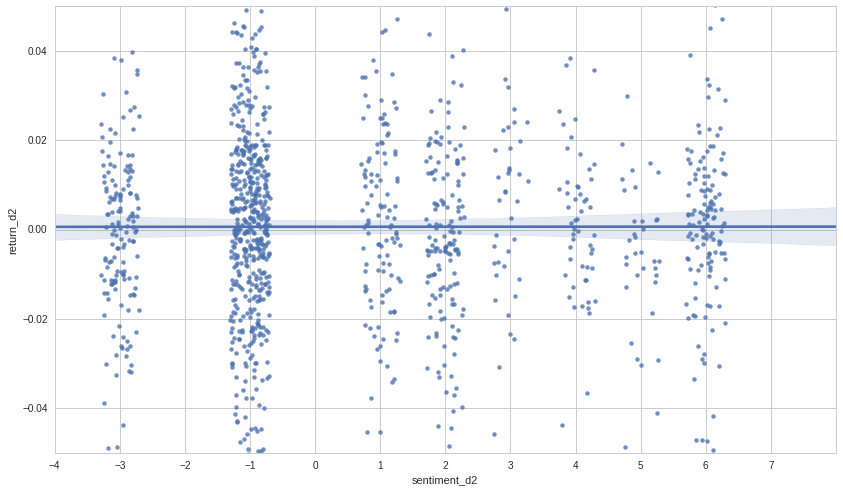

In [9]:
# Todo: Zoom in with `set_ylim()` function
ax = sns.regplot(x='sentiment_d2', y='return_d2', data=final_mdf, x_jitter=0.3)
ax.xaxis.set_ticks(np.arange(-4, 8, 1))
ax.set_ylim(-0.05, 0.05);

As it turned out, we do not see a conceivable pattern here. Let's group by sector and plot the regression for each sector to see if the trends are more significant when we compare them on per sector-basis.

## 3. Building a Multivariate Plot

In this section, you will create a multivariate plot, that is, a plot with three variables. The third variable here is the sectors. We will create a similar plot to the previous one, but use a different color for each sector.

### 3.1. Re-run the Pipeline + Sector Column

To do this, we need to re-run the pipeline, this time with the sector column included.

In [10]:
# Do not change anything in this code cell

from quantopian.pipeline.classifiers.morningstar import Sector

In [11]:
# Todo: Recreate the pipeline. Create and include Sector factor.

sector = Sector(mask=assets)

sector_pipe = Pipeline(
    columns={
        'sentiment_d2': sentiment_d2,
        'return_d2': return_d2,
        'sector': sector
    },
    screen=assets
)

sector_mdf = run_pipeline(sector_pipe, start_date, end_date)

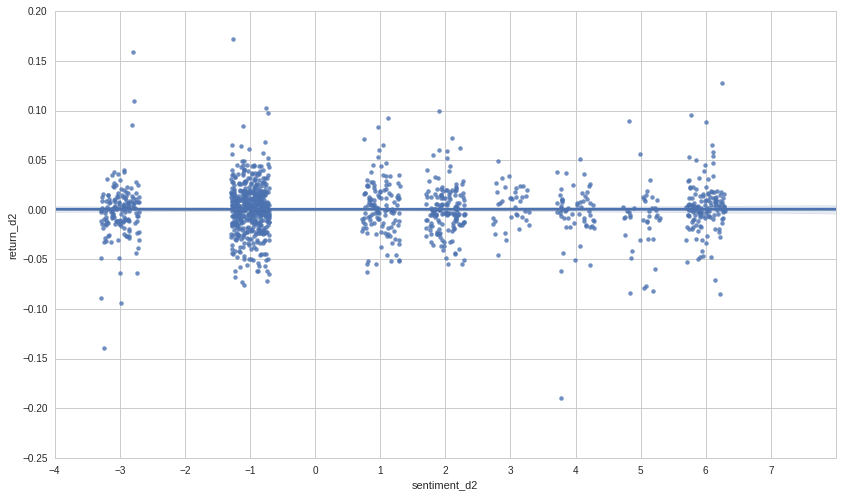

In [12]:
# Todo: Create a regplot.
ax = sns.regplot(x='sentiment_d2', y='return_d2', data=sector_mdf, x_jitter=0.3)
ax.xaxis.set_ticks(np.arange(-4, 8, 1));

In [13]:
sector_mdf.head(5)

return_d2  sector  \
2018-01-03 00:00:00+00:00 Equity(16841 [AMZN])   0.016639     102   
                          Equity(23709 [NFLX])   0.047235     102   
                          Equity(39840 [TSLA])   0.028548     102   
                          Equity(42950 [FB])     0.027816     311   
                          Equity(46631 [GOOG])   0.017707     311   

                                                sentiment_d2  
2018-01-03 00:00:00+00:00 Equity(16841 [AMZN])          -1.0  
                          Equity(23709 [NFLX])           6.0  
                          Equity(39840 [TSLA])           2.0  
                          Equity(42950 [FB])            -1.0  
                          Equity(46631 [GOOG])           1.0

### 3.2. Choose a Color Palette

Before visualizing multivariate plots, we first choose a color palette to use. Some of the available palettes are documented [here](https://seaborn.pydata.org/tutorial/color_palettes.html). Since we are dealing with discrete data, *paired* palette seems like a good idea.

First, get the list of sectors by getting unique values of `sector_mdf['sector']`, then use it as the number of colors.

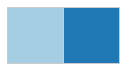

In [14]:
sectors = sector_mdf['sector'].unique()
pal = sns.color_palette('Paired', len(sectors))
sns.palplot(pal)

### 3.3. Visualize with lmplot

And finally, we can use `lmplot()` function to visualize all the fields in our DataFrame.

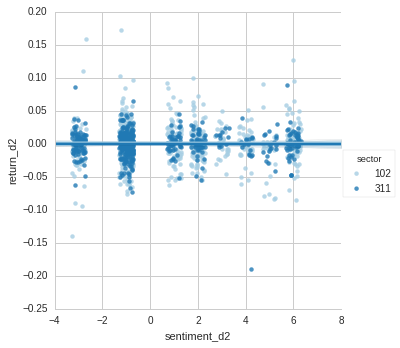

In [15]:
# Todo: Create an lmplot.
sns.lmplot(x='sentiment_d2', y='return_d2', hue='sector',
           data=sector_mdf, x_jitter=0.3, palette=pal);

## 3.4. Visualize with multiple regplots

For practice, draw the same plot with multiple regplots. Here are the tasks involved:

1. Prepare a legend elements list.
2. Loop over the list of sector codes. In each loop:
3. Get data for that sector using pandas selection by values.
4. Create a regplot with the data and color associated with the sector. Attach this plot to the Axes object passed through the arguments.
5. Add a Line2D instance to the list of legend elements.
6. (Outside of the loop) Attach a legend that contains the legend elements to the Axes object.

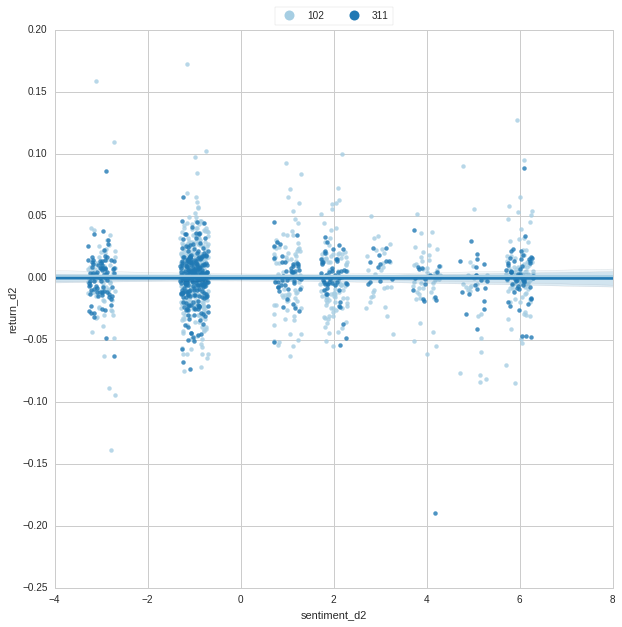

In [16]:
# Todo: Complete the `draw_plot` function below.

def draw_plot(x, y, hue, data, ax, sectors, pal):
    # 1. Todo: Prepare a legend elements list.
    legend_elements = []
    
    # 2. Todo: Loop over the list of sector codes.
    for i in range(len(sectors)):
        
        # 3. Todo: Get data for that sector using pandas selection by values.
        df = data[data[hue] == sectors[i]]
        
        # 4. Todo: Create a regplot with the data and color associated 
        #          with the sector. Attach this plot to the Axes object
        #          passed through the arguments.
        color = pal[i]
        facet = sns.regplot(x=x, y=y, data=df, color=color, ax=ax,
                            x_jitter=0.3)
        
        # 5. Todo: Add a Line2D instance to the list of legend elements.
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color='w',
                       label=sectors[i],
                       markerfacecolor=color, markersize=10)
        )
    
    # 6. Todo: Attach a legend that contains the legend elements
    #          to the Axes object.
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, 1.05),
              loc='upper center', ncol=2)
        

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
draw_plot('sentiment_d2', 'return_d2', 'sector', sector_mdf, ax, sectors, pal)